Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [8]:
pickle_file = 'notMNIST.pickle'
sanitized_file = 'notMNIST_sanitized_test.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

with open(sanitized_file, 'rb') as f:
    testsets = pickle.load(f)
    stest_dataset = testsets['test_dataset']
    stest_labels = testsets['test_labels']
    svalid_dataset = testsets['valid_dataset']
    svalid_labels = testsets['valid_labels']
    del testsets
    print('Sanitized validation set', svalid_dataset.shape, svalid_labels.shape)
    print('Sanitized test set', stest_dataset.shape, stest_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)
Sanitized validation set (8928, 28, 28) (8928,)
Sanitized test set (8670, 28, 28) (8670,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [9]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
stest_dataset, stest_labels = reformat(stest_dataset, stest_labels)
svalid_dataset, svalid_labels = reformat(svalid_dataset, svalid_labels)
print('Sanitized validation set', svalid_dataset.shape, svalid_labels.shape)
print('Sanitized test set', stest_dataset.shape, stest_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)
Sanitized validation set (8928, 784) (8928, 10)
Sanitized test set (8670, 784) (8670, 10)


In [10]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [11]:
# Cell author : Hoang NT
# Cell : Global variables, imports and helper functions

import math
import matplotlib.pyplot as plt
from IPython.display import display, Image
from scipy import ndimage

%matplotlib inline

IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

def scale_dev(dsize) :
    return 1.0 / math.sqrt(float(dsize))

def randomize(dataset, labels) :
    perm = np.random.permutation(labels.shape[0])
    return dataset[perm], labels[perm]


---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [10]:
# Cell author : Hoang NT
# Cell : Logistic model with regularization

_alpha = 0.1 # Learning rate
_beta = 0.005 # Regularization factor
num_labels = 10
num_step = 8000
batch_size = 128
logis_scope = 'logistic'

# Quick flag
logis_train = True

# Build the computational graph
# Input:
### data_dataset - tf.placeholder - Input data for calculation
### num_labels - int - length of onehot label vector
# Output:
### logits - tf.Tensor - Result of computation
def logistic_inference(train_data) :
    # Weight matrix initialized as randomized matrix
    with tf.variable_scope(logis_scope) :
        weights = tf.get_variable('weights',
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal(
                                                [IMAGE_PIXELS, num_labels],
                                                stddev=scale_dev(IMAGE_PIXELS)))
        biases = tf.get_variable('biases', initializer=tf.zeros([num_labels]))
    logits = tf.matmul(train_data, weights) + biases
    return logits

# Add loss function with regularization term to the graph
# Input:
### logits - tf.Tensor - output node of inference
### labels - tf.placeholder - training labels to computute loss
### beta - float - regularization factor
# Output:
### loss - tf.Tensor - result node of loss computation
def logistic_loss(logits, labels, beta) :
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits, labels, name='xentropy')
    # Get weights node
    with tf.variable_scope(logis_scope) :
        tf.get_variable_scope().reuse_variables()
        weights = tf.get_variable('weights', [IMAGE_PIXELS, num_labels])
    loss_p = tf.reduce_mean(xentropy, name='mean_xentropy') 
    regu = beta * tf.nn.l2_loss(weights)
    loss = loss_p + regu
    return loss

# Create training operations with SGD optimizer
# Input:
### loss - tf.Tensor - loss function result node
### learning_rate - float - learning rate for SGD
# Output:
### train_op - tf.Tensor - operation node to run optimizer
def logistic_training(loss, learning_rate) :
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    return train_op

graph = tf.Graph()
with graph.as_default() :
    # Create placeholder for training data and labels
    tf_train_dataset = tf.placeholder(dtype=tf.float32, shape=[None, IMAGE_PIXELS])
    tf_train_labels = tf.placeholder(dtype=tf.float32, shape=[None, num_labels])
    # Add computational nodes to graph
    logits = logistic_inference(tf_train_dataset)
    loss = logistic_loss(logits, tf_train_labels, _beta)
    train_op = logistic_training(loss, _alpha)
    init = tf.initialize_all_variables()
    # Prediction output for each batch
    predictions_softmax = tf.nn.softmax(logits)
    with tf.Session() as session :
        session.run(init)
        for step in range(num_step) :
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Training data for each batch
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, 
                         tf_train_labels : batch_labels}
            _, l, predictions = session.run([train_op, loss, predictions_softmax],
                                           feed_dict = feed_dict)
            if (step % 500 == 0) :
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions,
                                                              batch_labels))
            if (step % 50 == 0) :
                randomize(train_dataset, train_labels)
        
        # Get weights for visualization
        with tf.variable_scope(logis_scope):
            tf.get_variable_scope().reuse_variables()
            weights = tf.get_variable('weights', [IMAGE_PIXELS, num_labels])
        
        # Validation step
        valid_dict = {tf_train_dataset : valid_dataset}
        predictions, np_weights = session.run([predictions_softmax, weights],
                                               feed_dict=valid_dict)
        print("Validation data accuracy: %.1f%%"
              % accuracy(predictions, valid_labels))
        
        

    

Minibatch loss at step 0: 2.314857
Minibatch accuracy: 10.9%
Minibatch loss at step 500: 0.860063
Minibatch accuracy: 78.9%
Minibatch loss at step 1000: 0.829281
Minibatch accuracy: 76.6%
Minibatch loss at step 1500: 0.762297
Minibatch accuracy: 82.8%
Minibatch loss at step 2000: 0.822789
Minibatch accuracy: 78.1%
Minibatch loss at step 2500: 0.865590
Minibatch accuracy: 81.2%
Minibatch loss at step 3000: 0.789147
Minibatch accuracy: 79.7%
Minibatch loss at step 3500: 0.684425
Minibatch accuracy: 83.6%
Minibatch loss at step 4000: 0.655271
Minibatch accuracy: 84.4%
Minibatch loss at step 4500: 0.722902
Minibatch accuracy: 79.7%
Minibatch loss at step 5000: 0.781310
Minibatch accuracy: 79.7%
Minibatch loss at step 5500: 0.825230
Minibatch accuracy: 78.1%
Minibatch loss at step 6000: 0.699435
Minibatch accuracy: 84.4%
Minibatch loss at step 6500: 0.694292
Minibatch accuracy: 83.6%
Minibatch loss at step 7000: 0.763707
Minibatch accuracy: 84.4%
Minibatch loss at step 7500: 0.780489
Miniba

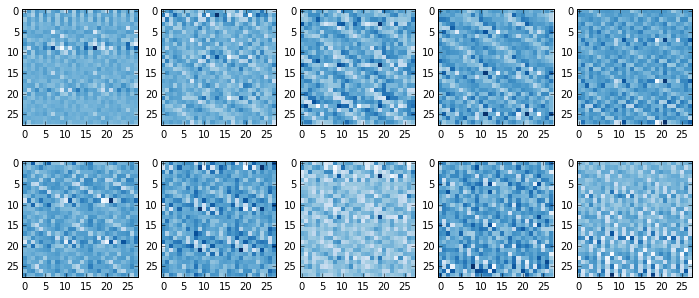

In [9]:
weights = np_weights.reshape((10,28,28))
plt.close('all')
plt.figure(figsize=(12,5))
plt.subplot(2,5,1)
plt.imshow(weights[0], cmap=plt.cm.Blues, interpolation='none') 
plt.subplot(2,5,2)
plt.imshow(weights[1], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,3)
plt.imshow(weights[2], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,4)
plt.imshow(weights[3], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,5)
plt.imshow(weights[4], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,6)
plt.imshow(weights[5], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,7)
plt.imshow(weights[6], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,8)
plt.imshow(weights[7], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,9)
plt.imshow(weights[8], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,10)
plt.imshow(weights[9], cmap=plt.cm.Blues, interpolation='none')

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [19]:
batch_size = 100
num_step = 1000
_beta = 0.5 # Disable regularization

graph = tf.Graph()
with graph.as_default() :
    tf_train_dataset = tf.placeholder(dtype=tf.float32, shape=[None,IMAGE_PIXELS])
    tf_train_labels = tf.placeholder(dtype=tf.float32, shape=[None,num_labels])
    logits = logistic_inference(tf_train_dataset)
    loss = logistic_loss(logits, tf_train_labels, _beta)
    train_op = logistic_training(loss, _alpha)
    init = tf.initialize_all_variables()
    predictions_softmax = tf.nn.softmax(logits)
    with tf.Session() as sess :
        sess.run(init)
        for step in range(num_step) :
            offset = 0
            # Training data for each batch
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, 
                         tf_train_labels : batch_labels}
            _, l, predictions = sess.run([train_op, loss, predictions_softmax],
                                           feed_dict = feed_dict)
            if (step % 50 == 0) :
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions,
                                                              batch_labels))
        # Validation step
        valid_dict = {tf_train_dataset : test_dataset}
        predictions = sess.run(predictions_softmax, feed_dict=valid_dict)
        print("Validation data accuracy: %.1f%%"
              % accuracy(predictions, test_labels))
        
        # Get weights for visualization
        with tf.variable_scope(logis_scope):
            tf.get_variable_scope().reuse_variables()
            weights = tf.get_variable('weights', [IMAGE_PIXELS, num_labels])
        
        # Sanitized test dataset
        f = open('notMNIST_sanitized_test.pickle', 'rb')
        testsets = pickle.load(f)
        san_test_dataset, san_test_labels = reformat(testsets.get('test_dataset'), 
                                                     testsets.get('test_labels'))
        san_test_dict = {tf_train_dataset : san_test_dataset}
        predictions, np_weights = sess.run([predictions_softmax, weights]
                                           , feed_dict = san_test_dict)
        print("Sanitized test dataset accuracy: %.1f%%" 
             % accuracy(predictions, san_test_labels))

Minibatch loss at step 0: 4.335188
Minibatch accuracy: 10.0%
Minibatch loss at step 50: 1.094598
Minibatch accuracy: 95.0%
Minibatch loss at step 100: 1.090454
Minibatch accuracy: 95.0%
Minibatch loss at step 150: 1.088063
Minibatch accuracy: 95.0%
Minibatch loss at step 200: 1.086368
Minibatch accuracy: 96.0%
Minibatch loss at step 250: 1.085165
Minibatch accuracy: 96.0%
Minibatch loss at step 300: 1.084310
Minibatch accuracy: 96.0%
Minibatch loss at step 350: 1.083700
Minibatch accuracy: 96.0%
Minibatch loss at step 400: 1.083262
Minibatch accuracy: 96.0%
Minibatch loss at step 450: 1.082947
Minibatch accuracy: 96.0%
Minibatch loss at step 500: 1.082719
Minibatch accuracy: 96.0%
Minibatch loss at step 550: 1.082553
Minibatch accuracy: 96.0%
Minibatch loss at step 600: 1.082430
Minibatch accuracy: 96.0%
Minibatch loss at step 650: 1.082340
Minibatch accuracy: 96.0%
Minibatch loss at step 700: 1.082273
Minibatch accuracy: 96.0%
Minibatch loss at step 750: 1.082222
Minibatch accuracy: 9

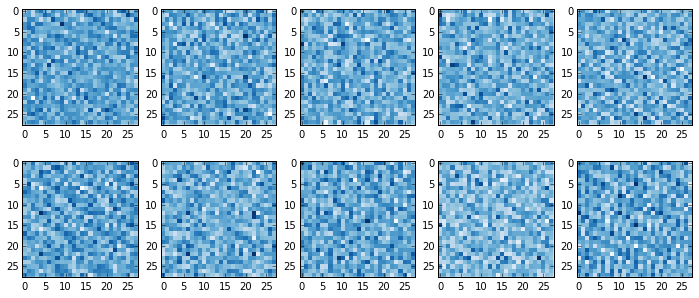

In [42]:
# Cell author : Hoang NT
# Cell : Visualize each colums of the weights as a 28x28 image

###### DONOT RE-RUN THIS CELL #######

# Case: extreme repetitive training dataset, 100% test accuracy, regularized.
weights = np_weights.reshape((10,28,28))
plt.close('all')
plt.figure(figsize=(12,5))
plt.subplot(2,5,1)
plt.imshow(weights[0], cmap=plt.cm.Blues, interpolation='none') 
plt.subplot(2,5,2)
plt.imshow(weights[1], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,3)
plt.imshow(weights[2], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,4)
plt.imshow(weights[3], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,5)
plt.imshow(weights[4], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,6)
plt.imshow(weights[5], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,7)
plt.imshow(weights[6], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,8)
plt.imshow(weights[7], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,9)
plt.imshow(weights[8], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,10)
plt.imshow(weights[9], cmap=plt.cm.Blues, interpolation='none')

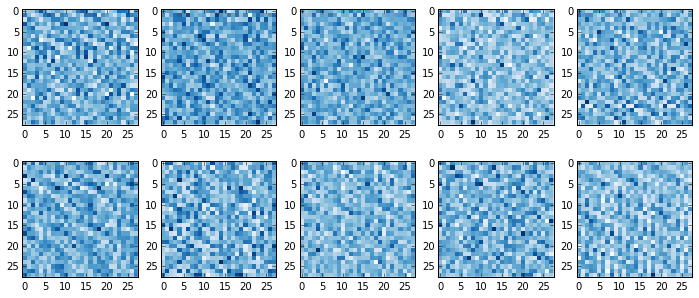

In [114]:
# Cell author : Hoang NT
# Cell : Visualize each colums of the weights as a 28x28 image

# Case: extreme repetitive training dataset, 100% test accuracy, no regularization.
weights = np_weights.reshape((10,28,28))
plt.close('all')
plt.figure(figsize=(12,5))
plt.subplot(2,5,1)
plt.imshow(weights[0], cmap=plt.cm.Blues, interpolation='none') 
plt.subplot(2,5,2)
plt.imshow(weights[1], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,3)
plt.imshow(weights[2], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,4)
plt.imshow(weights[3], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,5)
plt.imshow(weights[4], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,6)
plt.imshow(weights[5], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,7)
plt.imshow(weights[6], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,8)
plt.imshow(weights[7], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,9)
plt.imshow(weights[8], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,10)
plt.imshow(weights[9], cmap=plt.cm.Blues, interpolation='none')

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [ ]:
# log_dir to visualize the graph
log_dir = 'tf_log_dropout'


# Create a neural network with dropout in each hidden layer
# The original paper use dropout rate of 0.2 for input and 0.5 for hidden layers
# Input:
## train_data : tf.placeholder with shape (None, IMAGE_PIXELS)
## hidden_layers : list of hidden layer configuration
## keep_prob : list of placeholder type float for dropout
# Output:
## logits : tf.Tensor hold the final value
def dropout_inference(train_data, hidden_layers, keep_prob) :
    num_hidden_layers = len(hidden_layers)
    name = 'dropout_layer_'
    # Create weights, biases as variables and add the computation for hidden layers
    input_len = IMAGE_PIXELS
    data = train_data
    for i, num_nodes in enumerate(hidden_layers) :
        with tf.variable_scope(name + str(i)) :
            weights = tf.get_variable('weights',
                                     dtype=tf.float32,
                                     initializer=
                                      tf.truncated_normal([input_len, num_nodes],
                                                         stddev=scale_dev(IMAGE_PIXELS)))
            biases = tf.get_variable('biases', dtype=tf.float32, 
                                     initializer=tf.zeros([num_nodes]))
        # Update input data with dropout layer (layered matmul and addition)
        data = tf.nn.relu(tf.nn.dropout((tf.matmul(data, weights) + biases), keep_prob[i], 
                             name='dropout'), name = 'relu')
        # Summary ops to collect distribution
        w_hist = tf.histogram_summary('weights', weights)
        b_hist = tf.histogram_summary('biases', biases)
        h_hist = tf.histogram_summary('dropout_output', data)
        # Next weights matrix shape[0]
        input_len = num_nodes
    # Create output layer
    with tf.variable_scope('output_layer') :
        weights = tf.get_variable('weights',
                                 dtype=tf.float32,
                                 initializer=
                                  tf.truncated_normal([hidden_layers[-1], num_labels],
                                                     stddev=scale_dev(hidden_layers[-1])))
        biases = tf.get_variable('biases', dtype=tf.float32,
                                initializer=tf.zeros([num_labels]))
    logits = tf.add(tf.matmul(data, weights) ,biases, name='logits')
    return logits

# Create loss function
# Input:
## logits : tf.Tensor store logits value
## train_labels : tf.placeholder for labels
# Output:
## loss : tf.Tensor hold the result of the loss 
def dropout_loss(logits, train_labels) :
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits, train_labels, 
                                                      name='xentropy')
    loss = tf.reduce_mean(xentropy, name='xentropy_mean')
    loss_summary = tf.scalar_summary('cross entropy loss', loss)
    return loss

# Create training ops
# Input:
## loss : tf.Tensor store the loss function
## learning_rate : learning rate of SGD
# Output:
## train_op : tf.Tensor to run the training operation
def dropout_train(loss, learning_rate) :
    with tf.variable_scope('training') :
        global_step = tf.Variable(0) # Count number of step taken
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss, global_step=global_step)
    return train_op
    
# Accuracy measurement
# Input: 
## logits - tf.Tensor hold the computation
## labels - true label of the data
# Output:
## accuracy - tf.Tensor hold the accuracy
def dropout_acc(logits, labels) :
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) * 100
    return accuracy

def dropout_run(hidden_layers_cf, keep_prob_cf, learning_rate, num_step, batch_size, over_fit) :
    print ('==============================================')
    print ('hidden_layers_cf: %s | keep_prob_cf: %s | learning_rate: %s | num_step: %s | batch_size: %s | over_fit : %s |'
          % (str(hidden_layers_cf), str(keep_prob_cf), str(learning_rate), str(num_step), str(batch_size), str(over_fit)))
    graph = tf.Graph()
    with graph.as_default() :
        # Place holder to feed data
        tf_data = tf.placeholder(dtype=tf.float32, shape=[None, IMAGE_PIXELS])
        tf_labels = tf.placeholder(dtype=tf.float32, shape=[None, num_labels])
        # Hidden layer configurations
        hidden_config = hidden_layers_cf
        keep_prob = tf.placeholder(dtype=tf.float32, shape=[len(hidden_config)])
        # Build the graph
        logits = dropout_inference(tf_data, hidden_config, keep_prob)
        loss = dropout_loss(logits, tf_labels)
        train_op = dropout_train(loss, learning_rate)
        acc = dropout_acc(logits, tf_labels)
        with tf.Session() as sess :
            # Summary
            merged = tf.merge_all_summaries()
            writer = tf.train.SummaryWriter(log_dir, sess.graph_def)
            # Initialize all variables
            init = tf.initialize_all_variables()
            sess.run(init)
            # Feed data for test and validation
            test_dict = {tf_data : test_dataset, tf_labels : test_labels, 
                         keep_prob : [1.0]}
            valid_dict = {tf_data : valid_dataset, tf_labels : valid_labels,
                         keep_prob : [1.0]}
            # Test for overfit
            ok = 1
            if over_fit :
                ok = 0 # Keep offset_data at 0
            # Training process
            for i in range(num_step) :
                # Record performance on validation dataset
                if i % 1000 == 0 :
                    result = sess.run([merged, acc], feed_dict=valid_dict)
                    summary_str = result[0]
                    writer.add_summary(summary_str, i)

                offset = ok * (i * batch_size) % (train_labels.shape[0] - batch_size)
                feed_data = train_dataset[offset:(offset + batch_size)]
                feed_labels = train_labels[offset:(offset+batch_size)]
                train_dict = {tf_data : feed_data, tf_labels : feed_labels, 
                              keep_prob : keep_prob_cf}
                _, step_loss, step_acc  = sess.run([train_op, loss, acc], feed_dict=train_dict)
                if i % 2000 == 0 :
                    randomize(train_dataset, train_labels)
                if i % 500 == 0 :
                    print ("Step %d loss: %f" % (i, step_loss))
                    print ("Step %d accuracy: %.1f%%" % (i, step_acc))

            ac = sess.run(acc, feed_dict=test_dict)
            print ("Accuracy in test dataset: %s" % ac)
            
for learning_rates in [0.05, 0.1, 0.25, 0.5] :
    for batch_sizes in [128, 256, 512, 1024, 2000] :
        for num_step in [2560, 5120, 10240] :
            for hidden_layers_cf in [[256], [512], [1024], [2048]] :
                for keep_prob_cf in [[1], [0.8], [0.4], [0.2], [0.1]] :
                    for over_fit in [False] :
                        dropout_run(hidden_layers_cf, keep_prob_cf, learning_rates, num_step, batch_sizes, over_fit)
                    

hidden_layers_cf: [256] | keep_prob_cf: [1] | learning_rate: 0.05 | num_step: 2560 | batch_size: 128 | over_fit : False |
Step 0 loss: 2.270972
Step 0 accuracy: 19.5%
Step 500 loss: 0.746613
Step 500 accuracy: 78.9%
Step 1000 loss: 0.671384
Step 1000 accuracy: 78.9%
Step 1500 loss: 0.582257
Step 1500 accuracy: 83.6%
Step 2000 loss: 0.642093
Step 2000 accuracy: 84.4%
Step 2500 loss: 0.633752
Step 2500 accuracy: 82.0%
Accuracy in test dataset: 91.43
hidden_layers_cf: [256] | keep_prob_cf: [0.8] | learning_rate: 0.05 | num_step: 2560 | batch_size: 128 | over_fit : False |
Step 0 loss: 2.357931
Step 0 accuracy: 10.9%
Step 500 loss: 0.720517
Step 500 accuracy: 79.7%
Step 1000 loss: 0.703237
Step 1000 accuracy: 78.9%
Step 1500 loss: 0.676944
Step 1500 accuracy: 82.8%
Step 2000 loss: 0.667923
Step 2000 accuracy: 81.2%
Step 2500 loss: 0.655125
Step 2500 accuracy: 82.0%
Accuracy in test dataset: 91.56
hidden_layers_cf: [256] | keep_prob_cf: [0.4] | learning_rate: 0.05 | num_step: 2560 | batch_s

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [34]:
# Cell author : Hoang NT
# Cell : Neural network with dropout, mulilayers and learning rate decay

# Build custom multiplayered neural network for notMNIST
# Input :
## input_dropout - float - keep probability for input layer
## hidden_droput - array of float - keep probability for hidden layers - last element must be 1.0
## hidden_config - int - number of hidden nodes for each hidden layers - last element must be num_labels
## act_func - tf.Tensor - Tensorflow activation function for non-linearity
# Output :
## logits - tf.Tensor - Score of the graph computation
def custom_dropout_inference(hidden_dropout, hidden_config, act_func, input_data, data_len, input_dropout=None) :
    # Dropout at input layer
    logits = tf.nn.dropout(input_data, input_dropout)
    # Hidden layers and output layer
    scope_name = 'hidden_layer_'
    input_len = data_len
    for i, num_nodes in enumerate(hidden_config) :
        with tf.variable_scope(scope_name + str(i)) :
            weights = tf.get_variable('weights', dtype=tf.float32,
                                     initializer=tf.truncated_normal(shape=[input_len, num_nodes],
                                                                    stddev=scale_dev(input_len)))
            biases = tf.get_variable('biases', dtype=tf.float32, 
                                    initializer=tf.zeros(shape=[num_nodes]))
            logits = act_func(tf.nn.dropout((tf.matmul(logits, weights) + biases), hidden_dropout[i]))
            # For tensorboard
            w_hist = tf.histogram_summary('weights', weights)
            b_hist = tf.histogram_summary('biases', biases)
            h_hist = tf.histogram_summary('dropout_output', logits)
            # For next loop
            input_len = num_nodes
    return logits

# Create softmax cross-entropy loss function for the scores
# Input :
## logits - tf.Tensor - score of the computational graph
## input_labels - tf.placeholder - input labels
# Output :
## loss - tf.Tensor - cross entropy loss with true label
def custom_dropout_loss(logits, input_labels) :
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, input_labels, name='xentropy')
    loss = tf.reduce_mean(cross_entropy, name='loss')
    return loss

# SGD training operation. Exponential decay is continuous (staircase = False)
# Input :
## loss - tf.Tensor - loss function
## learning_rate - float - intial learning rate of SGD
## decay - boolean - true if exponential decay of learning rate
## decay_rate - float - decay rate
# Output :
## train_op - tf.Tensor - Training operation node to run in tf.Session
def custom_dropout_train(loss, learning_rate, decay, decay_rate, decay_step) :
    global_step = tf.Variable(0)
    learn_rate = learning_rate
    if decay :
        learn_rate = tf.train.exponential_decay(learning_rate, global_step, decay_step, decay_rate)
    optimizer = tf.train.GradientDescentOptimizer(learn_rate)
    train_op = optimizer.minimize(loss)
    return train_op

# Accuracy measurement
# Input: 
## logits - tf.Tensor hold the computation
## labels - true label of the data
# Output:
## accuracy - tf.Tensor hold the accuracy
def custom_dropout_acc(logits, labels) :
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) * 100
    return accuracy

In [60]:
# Cell author : Hoang NT
# Cell : Construct and run custom_dropout

log_dir = 'tf_dropout_log'

def run_custom_dropout(img_pixels, learning_rate, hidden_dropout, hidden_config, num_labels, 
                       act_func=tf.nn.relu, num_step=2560, decay=True, decay_rate=2.71828, 
                       decay_step=100000, input_dropout=1.0, batch_size=512) :
    graph = tf.Graph()
    with graph.as_default() :
        # Place holder to feed data
        tf_data = tf.placeholder(dtype=tf.float32, shape=[None, img_pixels])
        tf_labels = tf.placeholder(dtype=tf.float32, shape=[None, num_labels])
        # Hidden layer dropout configurations
        keep_prob = tf.placeholder(dtype=tf.float32, shape=[len(hidden_config)])
        # Input layer dropout configuration
        input_keep = tf.placeholder(dtype=tf.float32, shape=None)
        # Build the graph
        logits = custom_dropout_inference(hidden_dropout, hidden_config, tf.nn.relu, tf_data, 
                                          img_pixels, input_keep)
        loss = custom_dropout_loss(logits, tf_labels)
        train_op = custom_dropout_train(loss, learning_rate, decay, decay_rate, decay_step)
        acc = custom_dropout_acc(logits, tf_labels)
        with tf.Session() as sess :
            # Summary
            # merged = tf.merge_all_summaries()
            # writer = tf.train.SummaryWriter(log_dir, sess.graph_def)
            # Initialize all variables
            init = tf.initialize_all_variables()
            sess.run(init)
            # Feed data for test and validation
            test_dict = {tf_data : test_dataset, tf_labels : test_labels, 
                         keep_prob : np.ones_like(hidden_dropout), input_keep : 1.0}
            stest_dict = {tf_data : stest_dataset, tf_labels : stest_labels, 
                         keep_prob : np.ones_like(hidden_dropout), input_keep : 1.0}
            valid_dict = {tf_data : valid_dataset, tf_labels : valid_labels,
                         keep_prob : np.ones_like(hidden_dropout), input_keep : 1.0}
            svalid_dict = {tf_data : svalid_dataset, tf_labels : svalid_labels,
                         keep_prob : np.ones_like(hidden_dropout), input_keep : 1.0}
            # Training process
            for i in range(num_step) :
                # Record performance on validation dataset
                #if i % 1000 == 0 :
                #    result = sess.run([merged, acc], feed_dict=valid_dict)
                #    summary_str = result[0]
                #    writer.add_summary(summary_str, i)

                offset = (i * batch_size) % (train_labels.shape[0] - batch_size)
                feed_data = train_dataset[offset:(offset + batch_size)]
                feed_labels = train_labels[offset:(offset+batch_size)]
                train_dict = {tf_data : feed_data, tf_labels : feed_labels, 
                              keep_prob : hidden_dropout, input_keep : input_dropout}
                _, step_loss, step_acc  = sess.run([train_op, loss, acc], feed_dict=train_dict)
                if i % 256 == 0 :
                    print ("Step %d loss: %f" % (i, step_loss))
                    print ("Step %d accuracy: %.1f%%" % (i, step_acc))
                    
            # Get first layer's weights for visualization
            with tf.variable_scope('hidden_layer_0') : 
                tf.get_variable_scope().reuse_variables()
                weights = tf.get_variable('weights', shape=[IMAGE_PIXELS, hidden_config[0]])
            
            w1, ac = sess.run([weights, acc], feed_dict=valid_dict)
            print ("Accuracy in valid dataset: %s" % ac)
            ac = sess.run(acc, feed_dict=svalid_dict)
            print ("Accuracy in sanitized valid dataset: %s" % ac)
            
            # ac = sess.run(acc, feed_dict=test_dict)
            # print ("Accuracy in test dataset: %s" % ac)
            # ac = sess.run(acc, feed_dict=stest_dict)
            # print ("Accuracy in test dataset: %s" % ac)
    
    return w1

In [ ]:
visual_weights = run_custom_dropout(IMAGE_PIXELS, learning_rate=0.3, hidden_dropout=[0.8, 0.8, 0.8, 1.0], 
                   hidden_config=[1024, 512, 50, 10], num_labels=10, act_func=tf.nn.relu, 
                   num_step=300000, decay=True, decay_rate=2.71828, decay_step=50000, 
                   input_dropout=0.9, batch_size=32)

Step 0 loss: 2.293309
Step 0 accuracy: 21.9%
Step 256 loss: 0.766107
Step 256 accuracy: 81.2%
Step 512 loss: 0.752435
Step 512 accuracy: 71.9%
Step 768 loss: 0.542663
Step 768 accuracy: 78.1%
Step 1024 loss: 0.420362
Step 1024 accuracy: 90.6%
Step 1280 loss: 0.668807
Step 1280 accuracy: 78.1%
Step 1536 loss: 0.442819
Step 1536 accuracy: 87.5%
Step 1792 loss: 0.239770
Step 1792 accuracy: 93.8%
Step 2048 loss: 0.350606
Step 2048 accuracy: 87.5%
Step 2304 loss: 0.573709
Step 2304 accuracy: 87.5%
Step 2560 loss: 0.426229
Step 2560 accuracy: 84.4%


In [87]:
weights = visual_weights.T

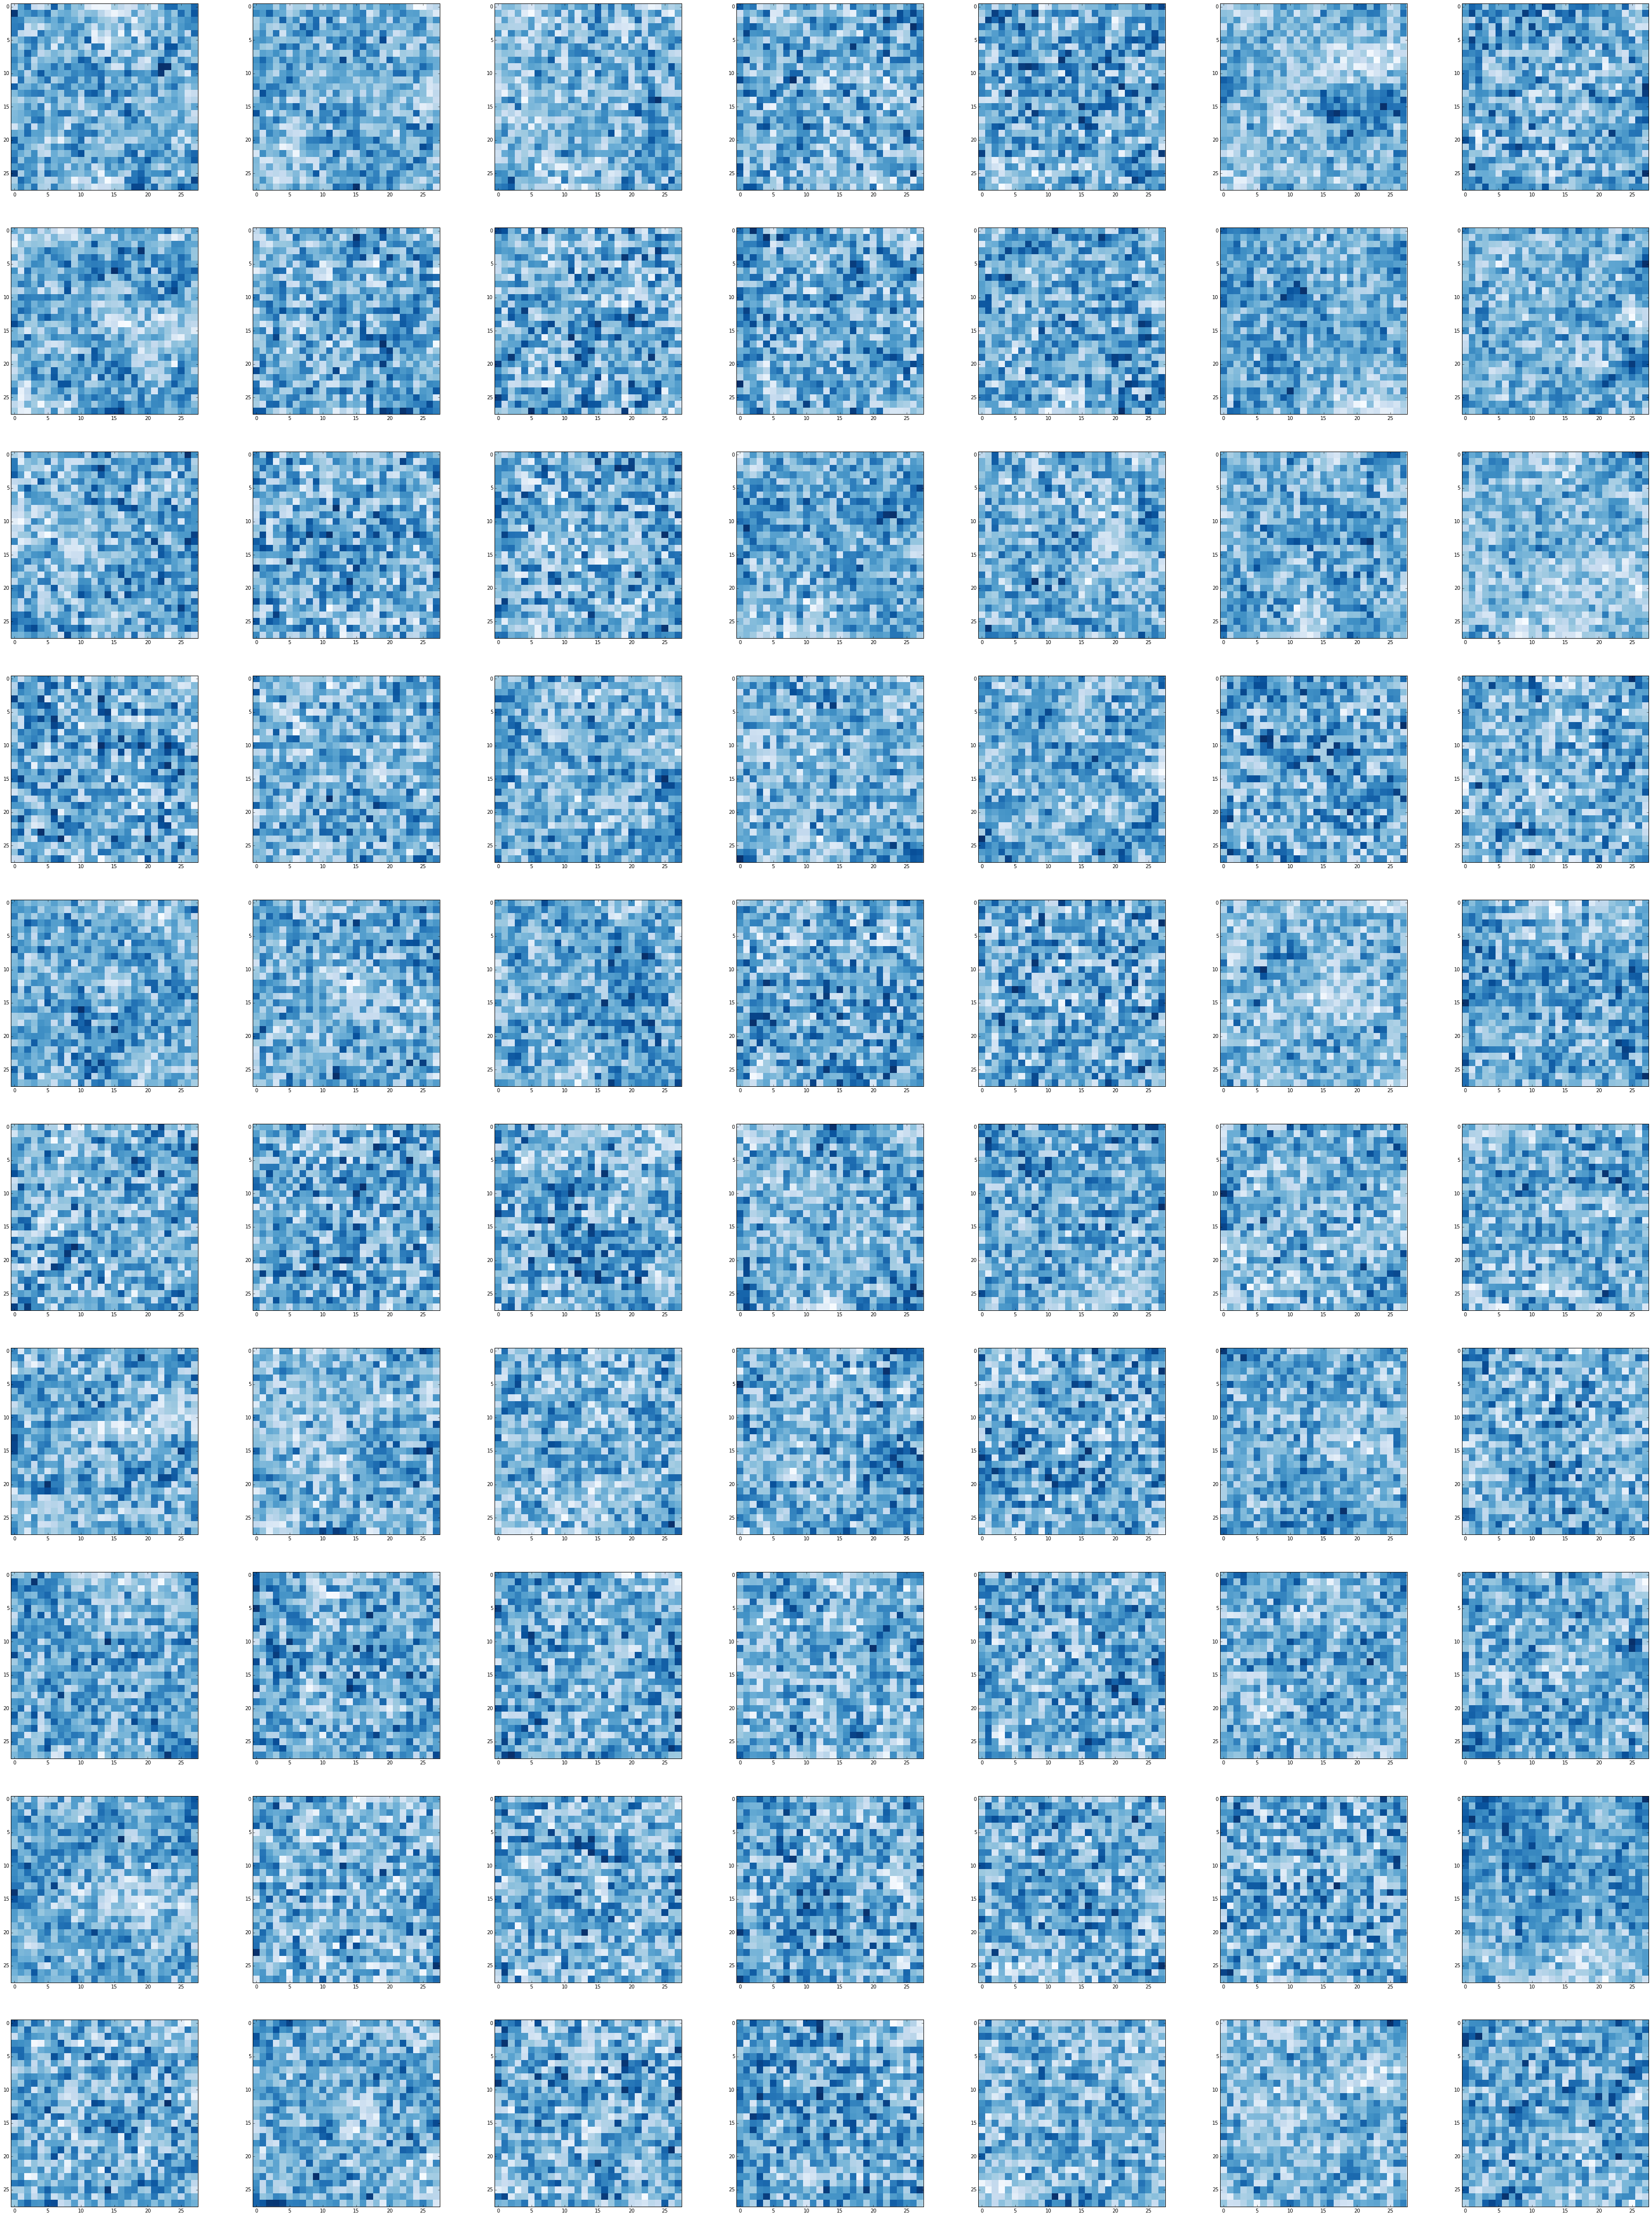

In [79]:
# Accuracy in valid dataset: 83
# Accuracy in sanitized valid dataset: 83
# 1000 iterations

weights = weights.reshape((1024,28,28))
plt.close('all')
plt.figure(figsize=(60,80))
for i in range(1,71) :
    plt.subplot(10,7,i)
    plt.imshow(weights[i], cmap=plt.cm.Blues, interpolation='none') 

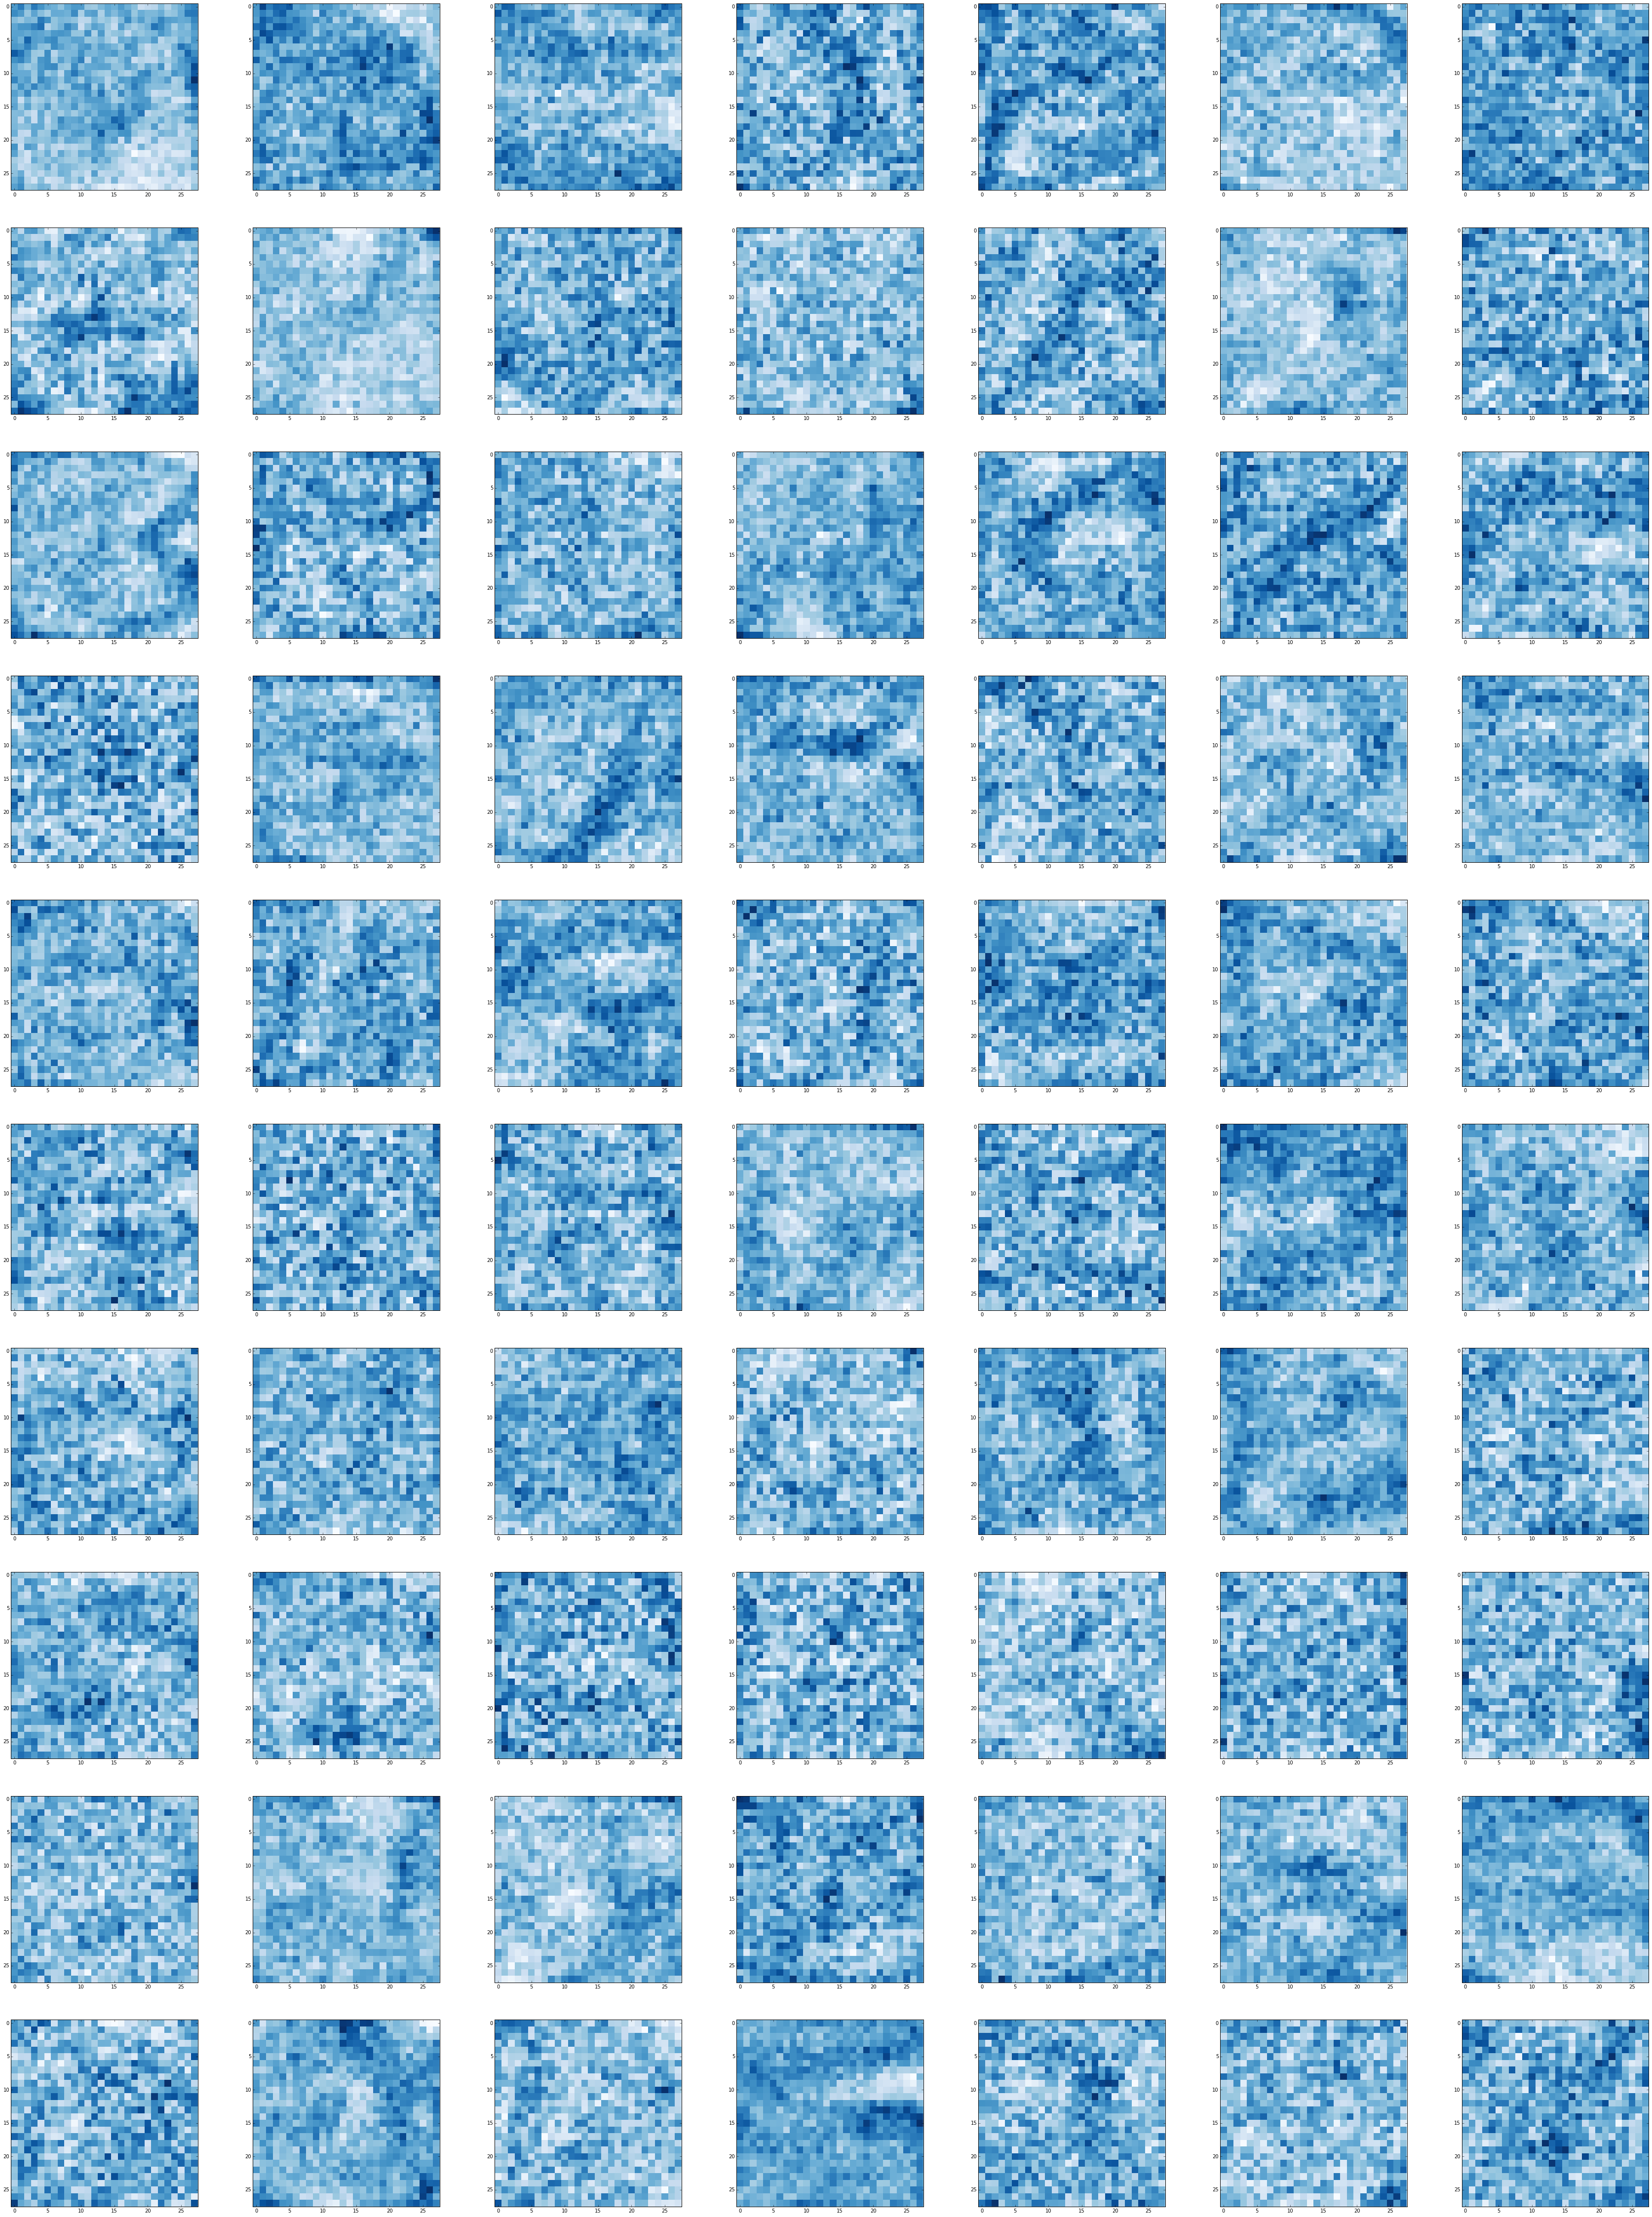

In [82]:
# Accuracy in valid dataset: 83
# Accuracy in sanitized valid dataset: 83
# 4000 iterations

weights = weights.reshape((1024,28,28))
plt.close('all')
plt.figure(figsize=(60,80))
for i in range(1,71) :
    plt.subplot(10,7,i)
    plt.imshow(weights[i], cmap=plt.cm.Blues, interpolation='none') 

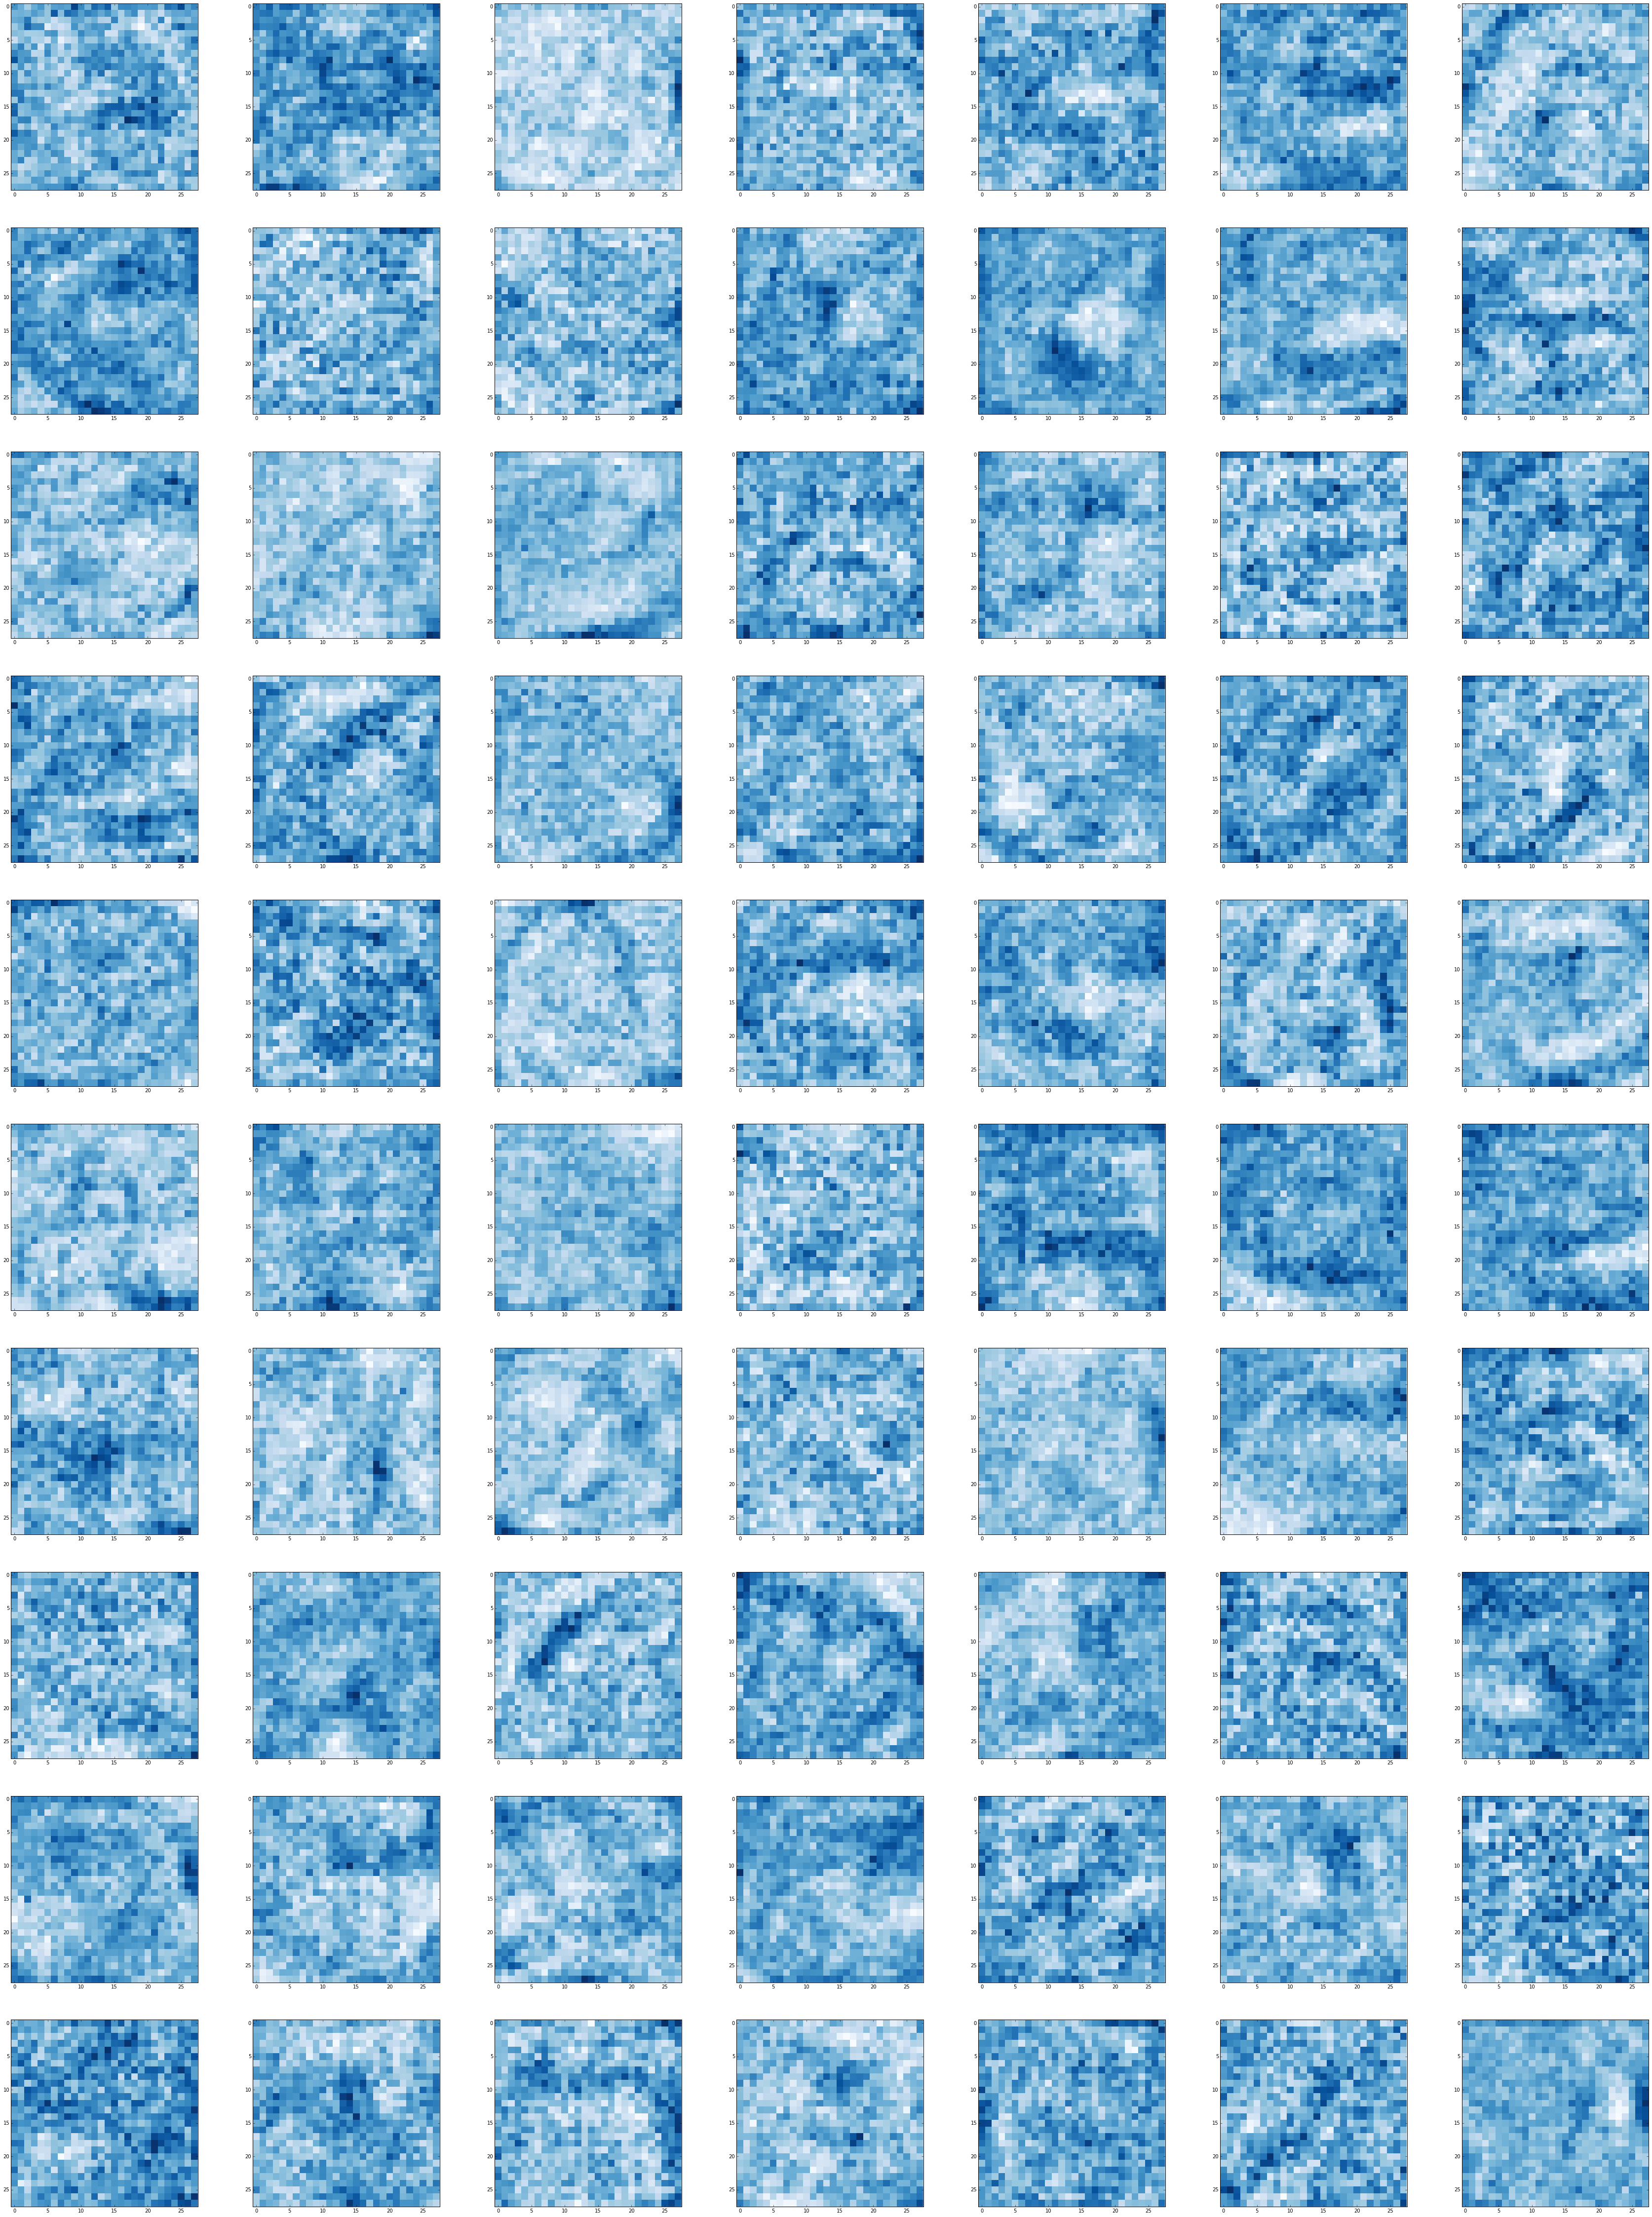

In [85]:
# Accuracy in valid dataset: 87.39
# Accuracy in sanitized valid dataset: 86.8168
# 15000 iterations

weights = weights.reshape((1024,28,28))
plt.close('all')
plt.figure(figsize=(60,80))
for i in range(1,71) :
    plt.subplot(10,7,i)
    plt.imshow(weights[i], cmap=plt.cm.Blues, interpolation='none') 

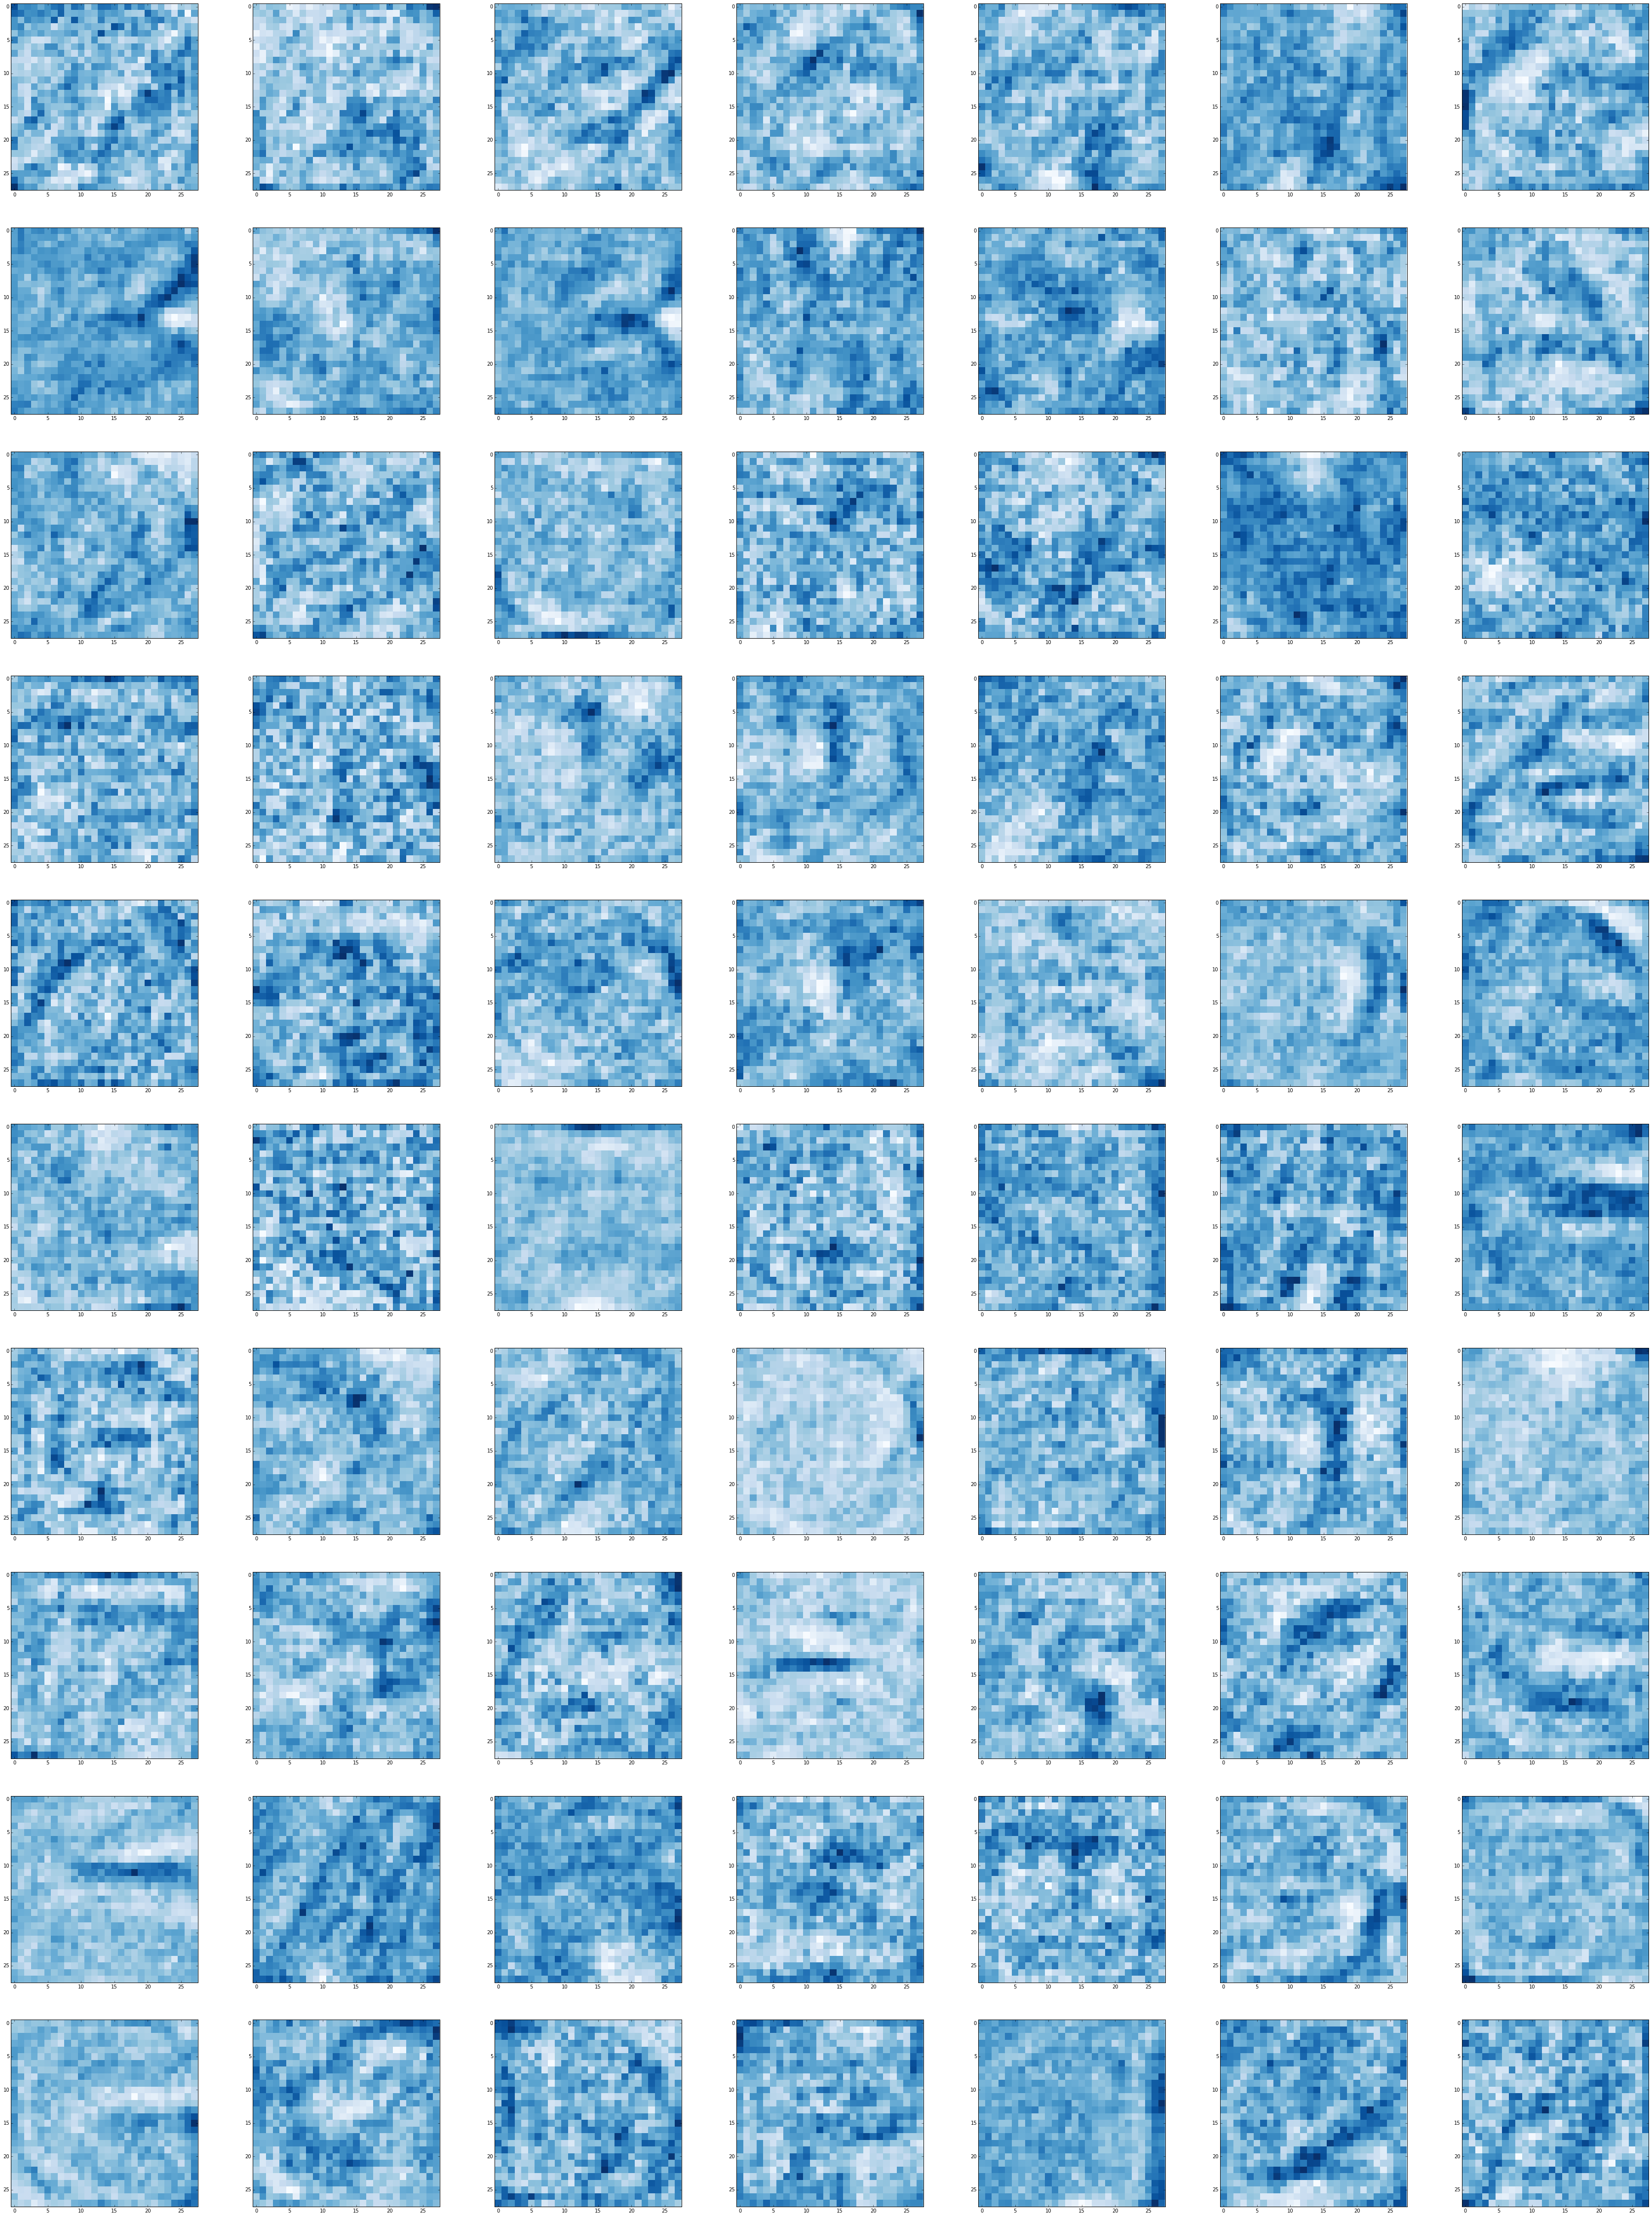

In [88]:
# Accuracy in valid dataset: 88.1
# Accuracy in sanitized valid dataset: 87.7
# 30000 iterations

weights = weights.reshape((1024,28,28))
plt.close('all')
plt.figure(figsize=(60,80))
for i in range(1,71) :
    plt.subplot(10,7,i)
    plt.imshow(weights[i], cmap=plt.cm.Blues, interpolation='none') 